# Class Activation Maps (CAM)

## MNIST Image Classification ConvNet with TensorFlow and Keras

This code defines a convolutional neural network model using TensorFlow and Keras for image classification on the MNIST dataset. It consists of several convolutional layers followed by max-pooling layers to extract features, and ends with a global average pooling layer and a dense layer for classification into 10 classes. The model is then compiled with the Adam optimizer and sparse categorical cross-entropy loss function. Finally, a summary of the model architecture is displayed.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Input
from tensorflow.keras import models
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# Define the input
input_img = Input(shape=(28, 28, 1))

# First Conv2D layer
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
# First MaxPooling layer
x = MaxPooling2D((2, 2))(x)

# Second Conv2D layer
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# Second MaxPooling layer
x = MaxPooling2D((2, 2))(x)

# Third Conv2D layer
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# Third MaxPooling layer
x = MaxPooling2D((2, 2))(x)

# Fourth Conv2D layer
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

# Global Average Pooling layer
x = GlobalAveragePooling2D()(x)

# Dense layer for classification
output = Dense(10, activation='softmax')(x)

# Define the model
model = Model(inputs=input_img, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496 

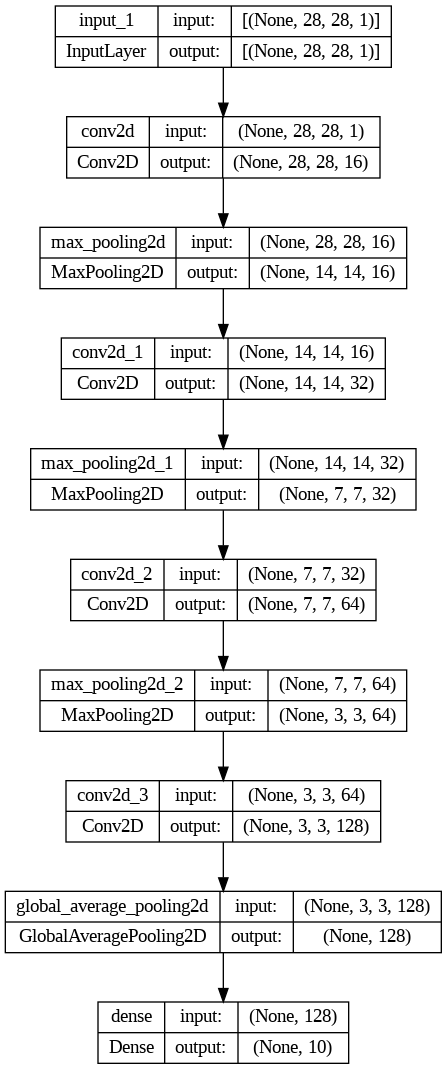

In [2]:
from tensorflow.keras.utils import plot_model
# Generate model plot
plot_model(model, to_file='convnet_model.png', show_shapes=True, show_layer_names=True)

 ## Training the Model

 This code segment loads the Fashion MNIST dataset, normalizes the pixel values of the images, and expands their dimensions to match the input shape required for the ConvNet model. It then trains the previously defined model on the normalized training images for 5 epochs, validating on the test set after each epoch.

In [3]:
# Load the Fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Expand dimensions to match the input shape (batch_size, height, width, channels)
train_images = np.expand_dims(train_images, -1)
test_images = np.expand_dims(test_images, -1)

# Train the model
model.fit(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels))


4422102/4422102 [==============================] - 0s 0us/step
Epoch 1/5
1875/1875 [==============================] - 14s 5ms/step - loss: 0.5916 - accuracy: 0.7808 - val_loss: 0.4319 - val_accuracy: 0.8421
Epoch 2/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3608 - accuracy: 0.8686 - val_loss: 0.3533 - val_accuracy: 0.8715
Epoch 3/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3027 - accuracy: 0.8883 - val_loss: 0.2974 - val_accuracy: 0.8905
Epoch 4/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2681 - accuracy: 0.9014 - val_loss: 0.2778 - val_accuracy: 0.8969
Epoch 5/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2460 - accuracy: 0.9099 - val_loss: 0.2660 - val_accuracy: 0.9032


## Visualizing Class Activation Maps (CAM) for Fashion MNIST

This code segment defines a function to generate and display Class Activation Maps (CAM) for images classified by the ConvNet trained on the Fashion MNIST dataset. CAM highlights regions in the input image that contribute most to the network's classification decision. The function takes the trained model, an input image, and the name of the target convolutional layer as inputs. It then computes the CAM using gradients obtained through backpropagation and visualizes the CAM overlaying the original image. Finally, it displays the original image alongside the CAM using matplotlib. This visualization aids in understanding where the model focuses its attention when making predictions, providing insights into its decision-making process.

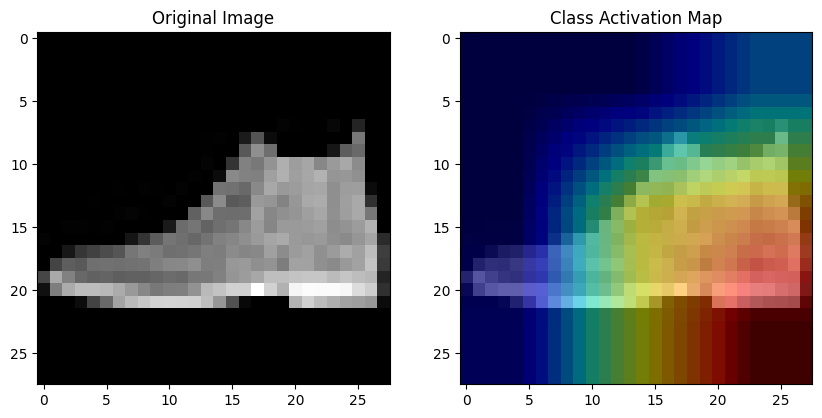

In [5]:
# Function to generate and display the CAM
def generate_cam(model, img, layer_name):
    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([img]))
        loss = predictions[:, np.argmax(predictions[0])]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))

    cam = np.zeros(output.shape[0:2], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    cam = np.uint8(255 * cam)
    cam = np.expand_dims(cam, axis=-1)
    cam = tf.image.resize(cam, (28, 28))

    return cam.numpy()

# Select an image from the test set
img = test_images[0]

# Generate the CAM
cam = generate_cam(model, img, 'conv2d_3')  # Last conv layer name

# Display the image and the CAM
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img.squeeze(), cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(img.squeeze(), cmap='gray')
plt.imshow(cam.squeeze(), cmap='jet', alpha=0.5)
plt.title('Class Activation Map')

plt.show()